# Applied Deep Learning - Course Project
### Detecting Cancer Metastases on Gigapixel Pathology Images
Xiaowei Zhao, Mingfeng Li

In [0]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

## **Data Loading**
Function read_slide is to read a region from the slide.
Functions find_tissue_pixels and apply_mask are used to improve efficiency by ignoring non-tissue areas of the slide. We'll find these by looking for all gray regions.

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

Data are stored on Google Drive.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('./drive/My Drive/slides')

In [0]:
!pwd

/content/drive/My Drive/slides


In [0]:
!ls

 tumor_001_mask.tif   tumor_031.xml	   tumor_081.tif
 tumor_001.tif	      tumor_035_mask.tif   tumor_081.xml
 tumor_001.xml	      tumor_035.tif	   tumor_084_mask.tif
 tumor_002_mask.tif   tumor_035.xml	   tumor_084.tif
 tumor_002.tif	     'tumor_038 (1).xml'   tumor_084.xml
 tumor_002.xml	      tumor_038.tif	   tumor_091_mask.tif
 tumor_005_mask.tif   tumor_038.xml	   tumor_091.tif
 tumor_005.tif	      tumor_057_mask.tif   tumor_091.xml
 tumor_005.xml	      tumor_057.tif	   tumor_094_mask.tif
 tumor_012_mask.tif   tumor_057.xml	   tumor_094.tif
 tumor_012.tif	      tumor_059_mask.tif   tumor_094.xml
 tumor_012.xml	      tumor_059.tif	   tumor_096_mask.tif
 tumor_016_mask.tif   tumor_059.xml	   tumor_096.tif
 tumor_016.tif	      tumor_064_mask.tif   tumor_096.xml
 tumor_016.xml	      tumor_064.tif	   tumor_099.xml
 tumor_019_mask.tif   tumor_064.xml	   tumor_101_mask.tif
 tumor_019.tif	      tumor_075_mask.tif   tumor_101.tif
 tumor_019.xml	      tumor_075.tif	   tumor_101.xml
 tumor_02

In [0]:
nmls = os.listdir()
slide = [x for x in nmls if x[9:]=='.tif']
mask = [x for x in nmls if x[-8:]=='mask.tif']
xml = [x for x in nmls if x[9:]=='.xml']

In [0]:
slide.remove('tumor_038.tif')
len(slide)

21

In [0]:
len(mask)

21

In [0]:
len(xml)

23


Getting local paths for the slides and masks.

In [0]:
slide_paths = []
tumor_mask_paths = []

for name in slide:
  slide_paths.append('/content/drive/My Drive/slides/%s' %name)
  
for name in mask:
  tumor_mask_paths.append('/content/drive/My Drive/slides/%s' %name)

In [0]:
slide_paths[0:2]

['/content/drive/My Drive/slides/tumor_091.tif',
 '/content/drive/My Drive/slides/tumor_001.tif']

In [0]:
tumor_mask_paths[0:2]

['/content/drive/My Drive/slides/tumor_091_mask.tif',
 '/content/drive/My Drive/slides/tumor_001_mask.tif']

Getting the openSlide objects for the slides and their masks.

In [0]:
slides = []
masks = []
for name in slide_paths:
  slides.append(open_slide(name))
for name in tumor_mask_paths:
  masks.append(open_slide(name))

In [0]:
assert len(slides)==len(masks)

In [0]:
slides[0:2]

[OpenSlide('/content/drive/My Drive/slides/tumor_091.tif'),
 OpenSlide('/content/drive/My Drive/slides/tumor_001.tif')]

In [0]:
masks[0:2]

[OpenSlide('/content/drive/My Drive/slides/tumor_091_mask.tif'),
 OpenSlide('/content/drive/My Drive/slides/tumor_001_mask.tif')]

## **Data Processing**
Sliding a window over the slides and masks and creating 299x299 patches of them. The level of origin image is set to be 3.

For each patch, check the percentage tissue in that patch, if percentage tissue > 20%, let the patch be zero, then plot the graph to check if the process of image is right.

In [0]:
patches = []
tumor_patches = []
pixel = 299

def create_patches(slides,masks,level,pixel):
  for k,slide in enumerate(slides[:1]):
    for j in range(0,slide.level_dimensions[level][1],pixel):
      for i in range(0,slide.level_dimensions[level][0],pixel):
        if i+pixel < slide.level_dimensions[level][0] and j+pixel < slide.level_dimensions[level][1]:
          patch = read_slide(slide,i*8,j*8,level = level, width = pixel,height = pixel) 
          mask_patch = read_slide(masks[k],i*8,j*8,level = level, width = pixel,height = pixel)  
          tumor_patch = mask_patch[:,:,0] 
          tissue_pixels = find_tissue_pixels(patch) 
          tissue_pixels = list(tissue_pixels)
          percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100 
          if np.count_nonzero(np.array(tumor_patch)) > 0:
            patches.append(patch)
            tumor_patches.append(tumor_patch)
          elif percent_tissue > 20:  
            patches.append(patch)
            tumor_patches.append(tumor_patch)
          else:
            zero = np.zeros((pixel,pixel))
            patches.append(zero)
            tumor_patches.append(zero)

In [0]:
create_patches(slides,masks,3,pixel)

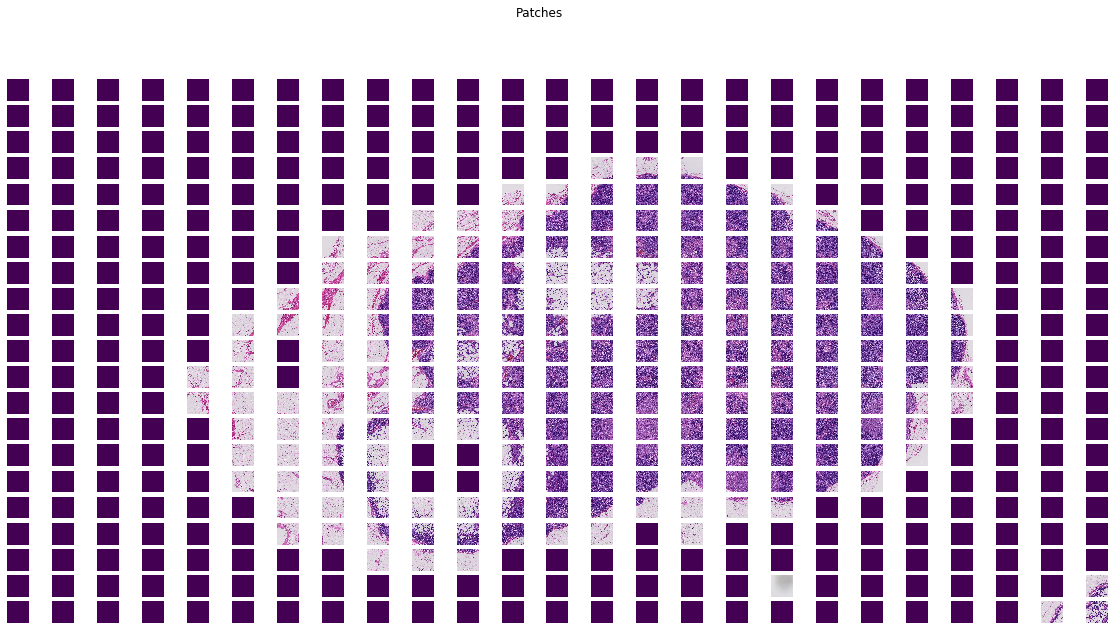

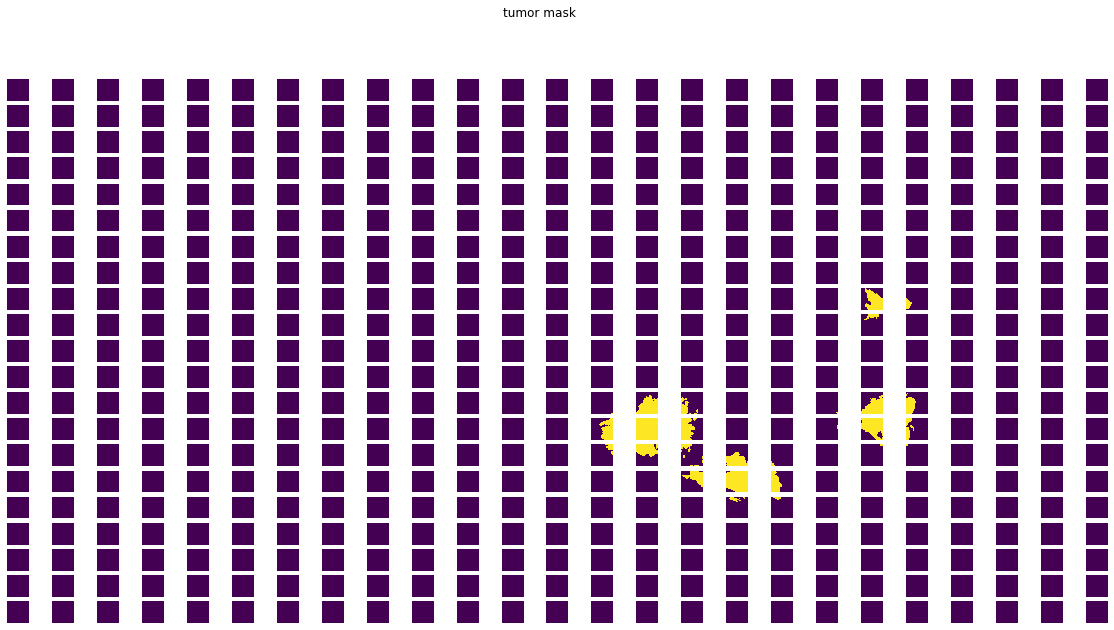

In [0]:
f, axes = plt.subplots(21, 25, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, 525):
    _ = ax[i].imshow(patches[i]);
    _ = ax[i].axis('off');
f.suptitle('Patches');

f, axes = plt.subplots(21, 25, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, 525):
    _ = ax[i].imshow(tumor_patches[i]);
    _ = ax[i].axis('off');
f.suptitle('tumor mask');



Again, sliding a window over the slides and masks and creating 299x299 patches of them.

Here, for each patch, check the percentage tissue in that patch, if percentage tissue < 20%, drop it.

In [0]:
patches = []
tumor_patches = []
pixel = 299

def create_patches(slides,masks,level,pixel):
  for k,slide in enumerate(slides):
    for j in range(0,slide.level_dimensions[level][1],pixel):
      for i in range(0,slide.level_dimensions[level][0],pixel):
        if i+pixel < slide.level_dimensions[level][0] and j+pixel < slide.level_dimensions[level][1]:
          patch = read_slide(slide,i*8,j*8,level = level, width = pixel,height = pixel) 
          mask_patch = read_slide(masks[k],i*8,j*8,level = level, width = pixel,height = pixel)  
          tumor_patch = mask_patch[:,:,0] 
          tissue_pixels = find_tissue_pixels(patch) 
          tissue_pixels = list(tissue_pixels)
          percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100 
          if np.count_nonzero(np.array(tumor_patch)) > 0:
            patches.append(patch)
            tumor_patches.append(tumor_patch)
          elif percent_tissue > 20:  
            patches.append(patch)
            tumor_patches.append(tumor_patch)

create_patches(slides,masks,3,pixel)

In [0]:
assert len(patches) == len(tumor_patches)

In [0]:
len(patches), len(tumor_patches)

(6348, 6348)

Converting Patches to numpy array.

In [0]:
patches = np.array(patches)
tumor_patches = np.array(tumor_patches)

In [0]:
import numpy as np
from scipy.ndimage import zoom

The function is to zoom in the patches. Center zoom in of the given image and returning an enlarged view of the image without changing dimensions.

In [0]:
import cv2
def cv2_clipped_zoom(img, zoom_factor):
    height, width = img.shape[:2]
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    bbox = (bbox / zoom_factor).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)
    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

Show some zoom-in examples

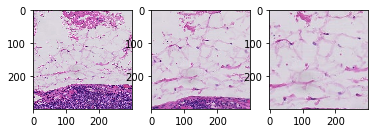

In [0]:
img = patches[1]
zm1 = cv2_clipped_zoom(img, 1.5)
zm2 = cv2_clipped_zoom(img, 2)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img)
ax[1].imshow(zm1)
ax[2].imshow(zm2)

Zoom in all patches and tumor patches

In [0]:
patches_zoomed = []

for img in patches:
  zm = cv2_clipped_zoom(img, 1.5)
  patches_zoomed.append(zm)

patches_zoomed = np.array(patches_zoomed)

In [0]:
tumor_patches_zoomed = []

for img in tumor_patches:
  zm = cv2_clipped_zoom(img, 1.5)
  tumor_patches_zoomed.append(zm)

tumor_patches_zoomed = np.array(tumor_patches_zoomed)

Assigning labels to each patch: 1 if there is at least one non-zero entry in the corresponding mask patch, 0 if not.

In [0]:
labels = []

for i in tumor_patches:
  if np.count_nonzero(i) > 0:
    labels.append(1)
  else :
    labels.append(0)
labels = np.array(labels)

Same, assigning labels to each zoomed patch: 1 if there is at least one non-zero entry in the corresponding mask patch, 0 if not.

In [0]:
labels_zoomed = []

for i in tumor_patches_zoomed:
  if np.count_nonzero(i) > 0:
    labels_zoomed.append(1)
  else :
    labels_zoomed.append(0)
labels_zoomed = np.array(labels_zoomed)

In [0]:
len(labels)

6348

In [0]:
len(labels_zoomed)

6348

Plot a slide patch and mask patch in label 1 to see if zoom-in works

In [0]:
index = np.where(labels == 1)[0]

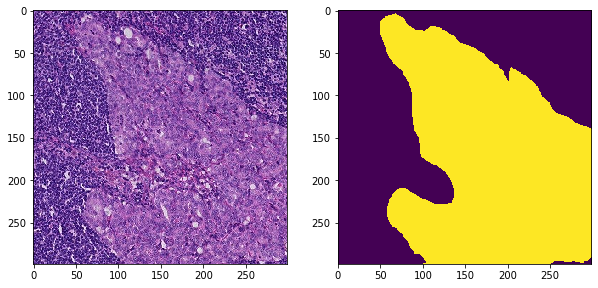

In [0]:
plt.figure(figsize= (10,5))
plt.subplot(1, 2, 1)
plt.imshow(patches[index[0]]) 
plt.subplot(1,2,2)
plt.imshow(tumor_patches[index[0]])

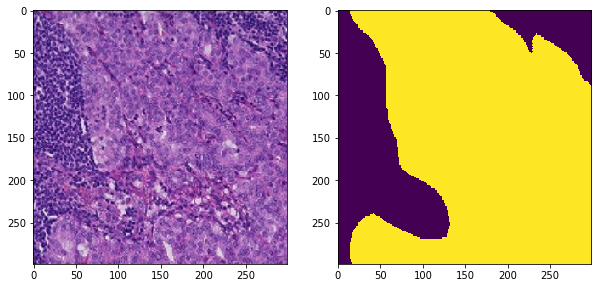

In [0]:
plt.figure(figsize= (10,5))
plt.subplot(1, 2, 1)
plt.imshow(patches_zoomed[index[0]]) 
plt.subplot(1,2,2)
plt.imshow(tumor_patches_zoomed[index[0]])

In [0]:
len(labels[labels == 1])

1055

In [0]:
len(labels[labels == 0])

5293

In [0]:
len(labels_zoomed[labels_zoomed == 1])

884

In [0]:
len(labels_zoomed[labels_zoomed == 0])

5464

## **Defining Network**

The data has high level of class imbalnace. Class 1 = Patches with tumors are limited.  The minority class is upsampled in the training sets.

In [0]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patches, labels_zoomed, stratify=labels_zoomed,test_size=0.2, random_state=123)

In [0]:
X_train_zoomed, X_test_zoomed, y_train_zoomed, y_test_zoomed = train_test_split(patches_zoomed, labels_zoomed, stratify=labels_zoomed,test_size=0.2, random_state=123)

In [0]:
class0_index = np.where(y_train_zoomed == 0)[0]
class1_index = np.where(y_train_zoomed == 1)[0]
class1_index_upsampled = np.random.choice(class1_index, size=len(class0_index), replace=True)

print("The number of class 0 is: {}".format(len(class0_index)))

X_train_upsampled = []
X_train_zoomed_upsampled = []

for i in class1_index_upsampled:
  X_train_upsampled.append(X_train[i])
  X_train_zoomed_upsampled.append(X_train_zoomed[i])

X_train_temp = []
X_train_zoomed_temp = []
for i in class0_index:
  X_train_temp.append(X_train[i])
  X_train_zoomed_temp.append(X_train_zoomed[i])

for i in X_train_upsampled:
  X_train_temp.append(i)

for i in X_train_zoomed_upsampled:
  X_train_zoomed_temp.append(i)

y_train_upsampled = list(y_train_zoomed[class1_index_upsampled])
y_train_temp = list(y_train_zoomed[class0_index])
for i in y_train_upsampled:
  y_train_temp.append(i)

X_train_balanced = np.array(X_train_temp)
y_train_balanced = np.array(y_train_temp)

X_train_zoomed_balanced = np.array(X_train_zoomed_temp)
y_train_zoomed_balanced = y_train_balanced

The number of class 0 is: 4371


In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


We concate two networks together to create a multi scale model, attempting to capture both details and contexts. Two scales used are 8X (level 3 dimension) and 12X.  

Model Details: 

Accuracy and F1 score are used as metrics to evaluate our model fitting on validation sets.
The optimier used is SGD with learning rate 0.1, decay at 1e-6 and momentum at 0.9.

In [0]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import models, applications, optimizers, callbacks
from tensorflow.keras import backend as K

In [0]:
def f1(ground_truth, prediction):
    def recall(ground_truth, prediction):       
        TP = K.sum(K.round(K.clip(ground_truth * prediction, 0, 1)))
        condition_positives = K.sum(K.round(K.clip(ground_truth, 0, 1)))
        recall = TP / (condition_positives + K.epsilon())
        return recall
    def precision(ground_truth, prediction):        
        TP = K.sum(K.round(K.clip(ground_truth * prediction, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(prediction, 0, 1)))
        precision = TP / (predicted_positives + K.epsilon())
        return precision 

    precision = precision(ground_truth, prediction)
    recall = recall(ground_truth, prediction)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input

In [0]:
model_base = applications.inception_v3.InceptionV3(weights=None,include_top = False,input_shape=(299,299,3))

model_out = Flatten(name='m_layer_1')(model_base.output)
model_out = Dense(128, activation='relu',name='m_layer_2')(model_out)
model = Model(model_base.input, model_out)

model_zoomed_base = applications.vgg16.VGG16(weights=None,include_top = False,input_shape=(299,299,3))
#model_zoomed_base.get_layer(name='mixed0').name='mixed0_1'
model_zoomed_out = Flatten(name='z_layer_1')(model_zoomed_base.output)
model_zoomed_out = Dense(128, activation='relu',name='z_layer_2')(model_zoomed_out)
model_zoomed = Model(model_zoomed_base.input, model_zoomed_out)

concatenated = concatenate([model_out, model_zoomed_out])
out = Dense(1, activation='sigmoid', name = 'output_layer')(concatenated)

merged_model = Model([model_base.input, model_zoomed_base.input], out)

In [0]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
rmsprop = optimizers.RMSprop(lr = 0.0001)
merged_model.compile(loss = 'binary_crossentropy',optimizer=sgd,metrics=['accuracy',f1])

## **Training Model**

In [0]:
merged_model.fit([X_train_balanced, X_train_zoomed_balanced], y_train_balanced, epochs=10 , validation_data=([X_test, X_test_zoomed], y_test_zoomed), shuffle = True)

Train on 8742 samples, validate on 1270 samples
Epoch 1/10
8742/8742 [==============================] - 183s 21ms/sample - loss: 0.6191 - accuracy: 0.7133 - f1: 0.6820 - val_loss: 0.6574 - val_accuracy: 0.7520 - val_f1: 0.3808
Epoch 2/10
8742/8742 [==============================] - 173s 20ms/sample - loss: 0.4100 - accuracy: 0.8270 - f1: 0.8112 - val_loss: 0.2865 - val_accuracy: 0.9102 - val_f1: 0.6971
Epoch 3/10
8742/8742 [==============================] - 173s 20ms/sample - loss: 0.3246 - accuracy: 0.8660 - f1: 0.8561 - val_loss: 0.3336 - val_accuracy: 0.9126 - val_f1: 0.6728
Epoch 4/10
8742/8742 [==============================] - 173s 20ms/sample - loss: 0.2904 - accuracy: 0.8868 - f1: 0.8792 - val_loss: 0.2771 - val_accuracy: 0.9142 - val_f1: 0.6605
Epoch 5/10
8742/8742 [==============================] - 173s 20ms/sample - loss: 0.2626 - accuracy: 0.9008 - f1: 0.8928 - val_loss: 0.3276 - val_accuracy: 0.9047 - val_f1: 0.6689
Epoch 6/10
8742/8742 [==============================] - 1

In [0]:
merged_model.fit([X_train_balanced, X_train_zoomed_balanced], y_train_balanced, epochs=10 , validation_data=([X_test, X_test_zoomed], y_test_zoomed), shuffle = True)

Train on 8742 samples, validate on 1270 samples
Epoch 1/10
8742/8742 [==============================] - 173s 20ms/sample - loss: 0.1565 - accuracy: 0.9445 - f1: 0.9398 - val_loss: 0.4670 - val_accuracy: 0.7669 - val_f1: 0.4992
Epoch 2/10
8742/8742 [==============================] - 173s 20ms/sample - loss: 0.1439 - accuracy: 0.9459 - f1: 0.9438 - val_loss: 0.4147 - val_accuracy: 0.8646 - val_f1: 0.6369
Epoch 3/10
8742/8742 [==============================] - 173s 20ms/sample - loss: 0.2537 - accuracy: 0.8989 - f1: 0.8903 - val_loss: 0.1642 - val_accuracy: 0.9425 - val_f1: 0.7777
Epoch 4/10
8742/8742 [==============================] - 173s 20ms/sample - loss: 0.1660 - accuracy: 0.9302 - f1: 0.9260 - val_loss: 0.2011 - val_accuracy: 0.9323 - val_f1: 0.7672
Epoch 5/10
8742/8742 [==============================] - 173s 20ms/sample - loss: 0.1547 - accuracy: 0.9299 - f1: 0.9235 - val_loss: 0.3221 - val_accuracy: 0.9268 - val_f1: 0.6243
Epoch 6/10
8742/8742 [==============================] - 1

## **Evaluating Model**

Five whole slides predictions are shown below in heatmaps along with the original slide and mask.

In [0]:
def show_heatmap(idx):
  index = idx
  test_slide = slides[index]
  test_slide.level_dimensions[3]
  test_slide_patches = []
  test_slide_patches_zoomed = []
  for j in range(0,test_slide.level_dimensions[3][1],pixel):
    for i in range(0,test_slide.level_dimensions[3][0],pixel):
      image = read_slide(test_slide,i*8,j*8,level = 3, width = pixel,height = pixel)
      test_slide_patches.append(image)
      zm = cv2_clipped_zoom(image, 1.5)
      test_slide_patches_zoomed.append(zm)
  test_slide_patches = np.array(test_slide_patches)
  test_slide_patches=test_slide_patches.astype('float32')
  test_slide_patches_zoomed = np.array(test_slide_patches_zoomed)
  test_slide_patches_zoomed=test_slide_patches_zoomed.astype('float32')

  predictions = merged_model.predict([test_slide_patches,test_slide_patches_zoomed])

  a=int(np.ceil(test_slide.level_dimensions[3][0]/299))
  b=int(np.floor(test_slide.level_dimensions[3][1]/299))
  c=int(a*b)
  predictions = predictions[:c]
  predictions = predictions.reshape((b,a))

  test_slide_image = read_slide(test_slide, 
                          x=0, 
                          y=0, 
                          level=3, 
                          width=test_slide.level_dimensions[3][0], 
                          height=test_slide.level_dimensions[3][1])

  test_mask = masks[index]
  test_mask_image = read_slide(test_mask, x = 0, y=0, level= 3, width = test_mask.level_dimensions[3][0], height = test_mask.level_dimensions[3][1])
  test_mask_image = test_mask_image[:,:,0]

  plt.figure(figsize = (10,20), dpi = 120)

  plt.subplot(1, 3, 1)
  plt.imshow(test_slide_image)

  plt.subplot(1, 3, 2)
  plt.imshow(test_mask_image)

  plt.subplot(1, 3, 3)
  plt.imshow(predictions) 

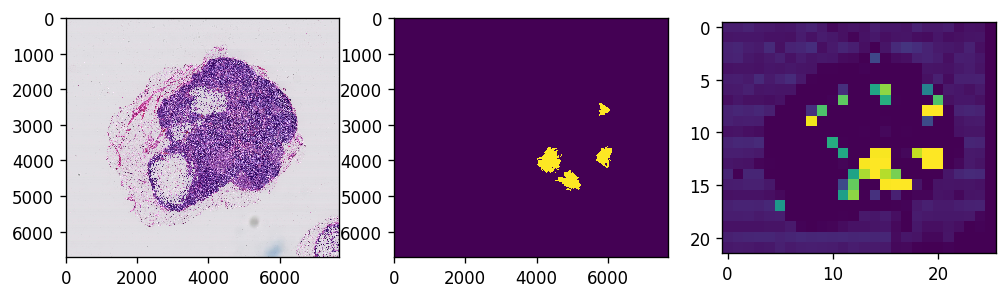

In [0]:
show_heatmap(0)

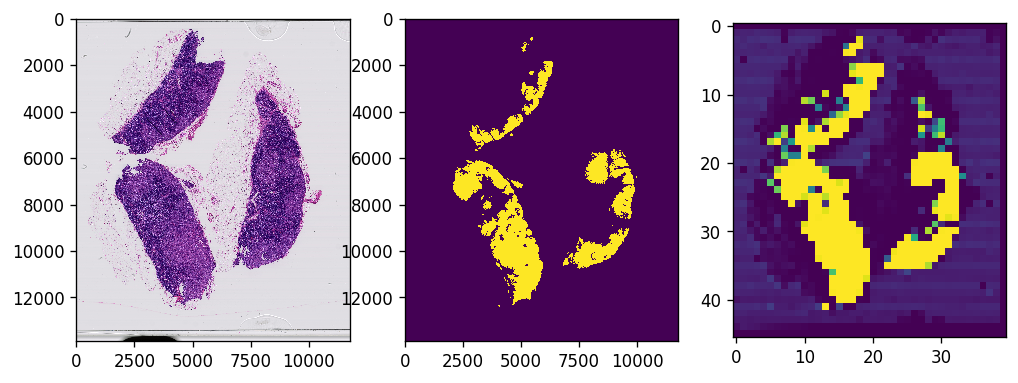

In [0]:
show_heatmap(14)

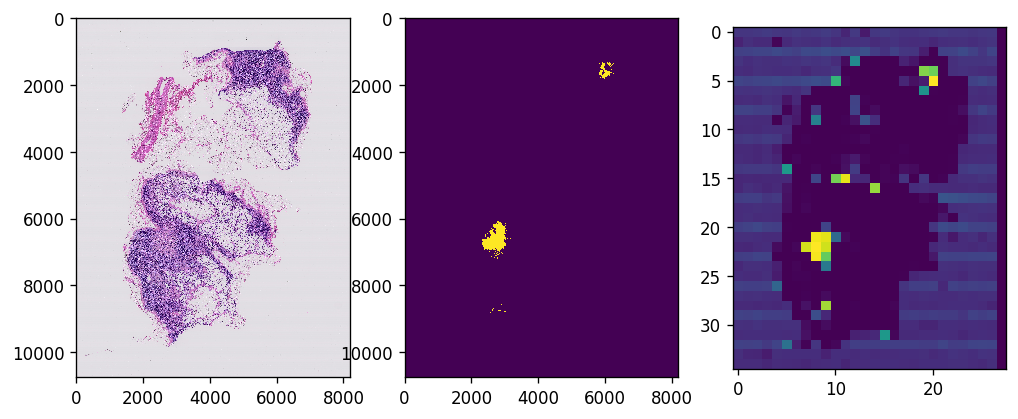

In [0]:
show_heatmap(16)

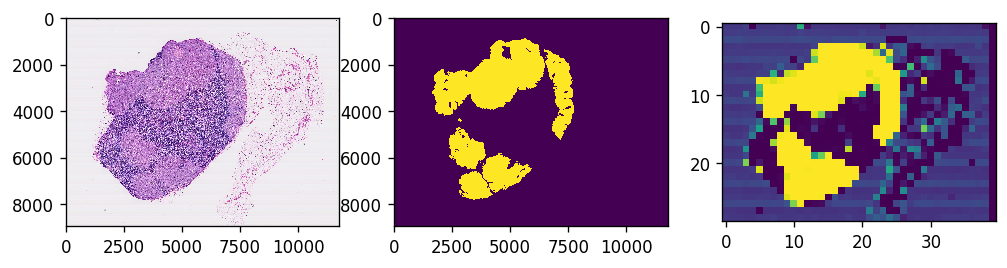

In [0]:
show_heatmap(19)

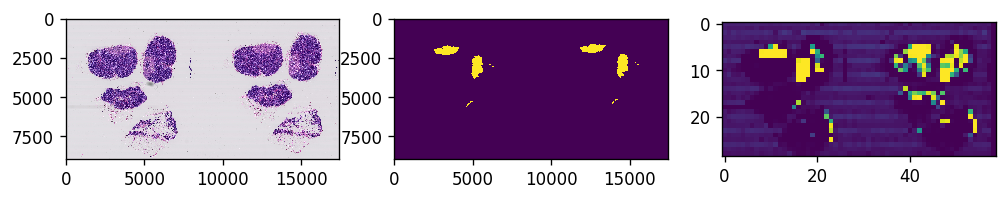

In [0]:
show_heatmap(20)